In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm
from sklearn.metrics import r2_score
from fastai.tabular.all import add_datepart
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import math
import time

tic_begin = time.time()

In [2]:
# check the number of data when start from 2022-01-01 to 2023-12-31
yf.pdr_override()
data_1 = pdr.get_data_yahoo("MSFT", start="2022-01-01", end="2022-12-31")
train_size = len(data_1) # 251

[*********************100%***********************]  1 of 1 completed


In [3]:
yf.pdr_override()
data_2 = pdr.get_data_yahoo("MSFT", start="2022-01-01", end="2023-04-01")
train_val = len(data_2) # 313

[*********************100%***********************]  1 of 1 completed


In [4]:
# read the stock data
yf.pdr_override()
data = pdr.get_data_yahoo("MSFT", start="2022-01-01", end="2023-05-30")
data # there are 352 data in total using as training and validation data
# to download the data, need the vpn
# training: data_1: 251 data; validation: 313-251 = 62 data; testing: 352-313 = 39 data

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  335.350006  338.000000  329.779999  334.750000  330.092224   
2022-01-04  334.829987  335.200012  326.119995  329.010010  324.432129   
2022-01-05  325.859985  326.070007  315.980011  316.380005  311.977875   
2022-01-06  313.149994  318.700012  311.489990  313.880005  309.512665   
2022-01-07  314.149994  316.500000  310.089996  314.040009  309.670441   
...                ...         ...         ...         ...         ...   
2023-05-22  318.600006  322.589996  318.010010  321.179993  321.179993   
2023-05-23  320.029999  322.720001  315.250000  315.260010  315.260010   
2023-05-24  314.730011  316.500000  312.609985  313.850006  313.850006   
2023-05-25  323.239990  326.899994  320.000000  325.920013  325.920013   
2023-05-26  324.019989  333.399994  323.880005  332.890015  332.890015   

              Volume  
Date                  
2022-01-03  28865100  
2022-01-04  32674300  
2022-01-05  40054300  
2022-01-06  39646100  
2022-01-07  32720000  
...              ...  
2023-05-22  24115700  
2023-05-23  30797200  
2023-05-24  23384900  
2023-05-25  43301700  
2023-05-26  36630600  

[352 rows x 6 columns]

In [5]:
pred_day = train_val
H = 39
# train_size = 251
val_size = train_val - train_size
N = 10

In [6]:
df = data.reset_index()
df

Date        Open        High         Low       Close   Adj Close  \
0   2022-01-03  335.350006  338.000000  329.779999  334.750000  330.092224   
1   2022-01-04  334.829987  335.200012  326.119995  329.010010  324.432129   
2   2022-01-05  325.859985  326.070007  315.980011  316.380005  311.977875   
3   2022-01-06  313.149994  318.700012  311.489990  313.880005  309.512665   
4   2022-01-07  314.149994  316.500000  310.089996  314.040009  309.670441   
..         ...         ...         ...         ...         ...         ...   
347 2023-05-22  318.600006  322.589996  318.010010  321.179993  321.179993   
348 2023-05-23  320.029999  322.720001  315.250000  315.260010  315.260010   
349 2023-05-24  314.730011  316.500000  312.609985  313.850006  313.850006   
350 2023-05-25  323.239990  326.899994  320.000000  325.920013  325.920013   
351 2023-05-26  324.019989  333.399994  323.880005  332.890015  332.890015   

       Volume  
0    28865100  
1    32674300  
2    40054300  
3    39646100  
4    32720000  
..        ...  
347  24115700  
348  30797200  
349  23384900  
350  43301700  
351  36630600  

[352 rows x 7 columns]

In [7]:
# add on Jun 20
lst_ori = list(df['Date'])
lst_to_add = list(pd.date_range(start='5/27/2023', end='6/2/2023'))
lst_ori.extend(lst_to_add)
df_add = pd.DataFrame({'Date': lst_ori})
# pd.concat([df_ori, df], join='outer', axis=1)
df = df_add.merge(df, how='left', on='Date')
df

Date        Open        High         Low       Close   Adj Close  \
0   2022-01-03  335.350006  338.000000  329.779999  334.750000  330.092224   
1   2022-01-04  334.829987  335.200012  326.119995  329.010010  324.432129   
2   2022-01-05  325.859985  326.070007  315.980011  316.380005  311.977875   
3   2022-01-06  313.149994  318.700012  311.489990  313.880005  309.512665   
4   2022-01-07  314.149994  316.500000  310.089996  314.040009  309.670441   
..         ...         ...         ...         ...         ...         ...   
354 2023-05-29         NaN         NaN         NaN         NaN         NaN   
355 2023-05-30         NaN         NaN         NaN         NaN         NaN   
356 2023-05-31         NaN         NaN         NaN         NaN         NaN   
357 2023-06-01         NaN         NaN         NaN         NaN         NaN   
358 2023-06-02         NaN         NaN         NaN         NaN         NaN   

         Volume  
0    28865100.0  
1    32674300.0  
2    40054300.0  
3    39646100.0  
4    32720000.0  
..          ...  
354         NaN  
355         NaN  
356         NaN  
357         NaN  
358         NaN  

[359 rows x 7 columns]

In [8]:
add_datepart(df, 'Date', drop=False)

Date        Open        High         Low       Close   Adj Close  \
0   2022-01-03  335.350006  338.000000  329.779999  334.750000  330.092224   
1   2022-01-04  334.829987  335.200012  326.119995  329.010010  324.432129   
2   2022-01-05  325.859985  326.070007  315.980011  316.380005  311.977875   
3   2022-01-06  313.149994  318.700012  311.489990  313.880005  309.512665   
4   2022-01-07  314.149994  316.500000  310.089996  314.040009  309.670441   
..         ...         ...         ...         ...         ...         ...   
354 2023-05-29         NaN         NaN         NaN         NaN         NaN   
355 2023-05-30         NaN         NaN         NaN         NaN         NaN   
356 2023-05-31         NaN         NaN         NaN         NaN         NaN   
357 2023-06-01         NaN         NaN         NaN         NaN         NaN   
358 2023-06-02         NaN         NaN         NaN         NaN         NaN   

         Volume  Year  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end  \
0    28865100.0  2022      1     1    3          0          3         False   
1    32674300.0  2022      1     1    4          1          4         False   
2    40054300.0  2022      1     1    5          2          5         False   
3    39646100.0  2022      1     1    6          3          6         False   
4    32720000.0  2022      1     1    7          4          7         False   
..          ...   ...    ...   ...  ...        ...        ...           ...   
354         NaN  2023      5    22   29          0        149         False   
355         NaN  2023      5    22   30          1        150         False   
356         NaN  2023      5    22   31          2        151          True   
357         NaN  2023      6    22    1          3        152         False   
358         NaN  2023      6    22    2          4        153         False   

     Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  \
0             False           False             False        False   
1             False           False             False        False   
2             False           False             False        False   
3             False           False             False        False   
4             False           False             False        False   
..              ...             ...               ...          ...   
354           False           False             False        False   
355           False           False             False        False   
356           False           False             False        False   
357            True           False             False        False   
358           False           False             False        False   

     Is_year_start       Elapsed  
0            False  1.641168e+09  
1            False  1.641254e+09  
2            False  1.641341e+09  
3            False  1.641427e+09  
4            False  1.641514e+09  
..             ...           ...  
354          False  1.685318e+09  
355          False  1.685405e+09  
356          False  1.685491e+09  
357          False  1.685578e+09  
358          False  1.685664e+09  

[359 rows x 20 columns]

In [9]:
df.drop('Elapsed', axis=1, inplace=True)
df

Date        Open        High         Low       Close   Adj Close  \
0   2022-01-03  335.350006  338.000000  329.779999  334.750000  330.092224   
1   2022-01-04  334.829987  335.200012  326.119995  329.010010  324.432129   
2   2022-01-05  325.859985  326.070007  315.980011  316.380005  311.977875   
3   2022-01-06  313.149994  318.700012  311.489990  313.880005  309.512665   
4   2022-01-07  314.149994  316.500000  310.089996  314.040009  309.670441   
..         ...         ...         ...         ...         ...         ...   
354 2023-05-29         NaN         NaN         NaN         NaN         NaN   
355 2023-05-30         NaN         NaN         NaN         NaN         NaN   
356 2023-05-31         NaN         NaN         NaN         NaN         NaN   
357 2023-06-01         NaN         NaN         NaN         NaN         NaN   
358 2023-06-02         NaN         NaN         NaN         NaN         NaN   

         Volume  Year  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end  \
0    28865100.0  2022      1     1    3          0          3         False   
1    32674300.0  2022      1     1    4          1          4         False   
2    40054300.0  2022      1     1    5          2          5         False   
3    39646100.0  2022      1     1    6          3          6         False   
4    32720000.0  2022      1     1    7          4          7         False   
..          ...   ...    ...   ...  ...        ...        ...           ...   
354         NaN  2023      5    22   29          0        149         False   
355         NaN  2023      5    22   30          1        150         False   
356         NaN  2023      5    22   31          2        151          True   
357         NaN  2023      6    22    1          3        152         False   
358         NaN  2023      6    22    2          4        153         False   

     Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  \
0             False           False             False        False   
1             False           False             False        False   
2             False           False             False        False   
3             False           False             False        False   
4             False           False             False        False   
..              ...             ...               ...          ...   
354           False           False             False        False   
355           False           False             False        False   
356           False           False             False        False   
357            True           False             False        False   
358           False           False             False        False   

     Is_year_start  
0            False  
1            False  
2            False  
3            False  
4            False  
..             ...  
354          False  
355          False  
356          False  
357          False  
358          False  

[359 rows x 19 columns]

In [10]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df

date        open        high         low       close   adj_close  \
0   2022-01-03  335.350006  338.000000  329.779999  334.750000  330.092224   
1   2022-01-04  334.829987  335.200012  326.119995  329.010010  324.432129   
2   2022-01-05  325.859985  326.070007  315.980011  316.380005  311.977875   
3   2022-01-06  313.149994  318.700012  311.489990  313.880005  309.512665   
4   2022-01-07  314.149994  316.500000  310.089996  314.040009  309.670441   
..         ...         ...         ...         ...         ...         ...   
354 2023-05-29         NaN         NaN         NaN         NaN         NaN   
355 2023-05-30         NaN         NaN         NaN         NaN         NaN   
356 2023-05-31         NaN         NaN         NaN         NaN         NaN   
357 2023-06-01         NaN         NaN         NaN         NaN         NaN   
358 2023-06-02         NaN         NaN         NaN         NaN         NaN   

         volume  year  month  week  day  dayofweek  dayofyear  is_month_end  \
0    28865100.0  2022      1     1    3          0          3         False   
1    32674300.0  2022      1     1    4          1          4         False   
2    40054300.0  2022      1     1    5          2          5         False   
3    39646100.0  2022      1     1    6          3          6         False   
4    32720000.0  2022      1     1    7          4          7         False   
..          ...   ...    ...   ...  ...        ...        ...           ...   
354         NaN  2023      5    22   29          0        149         False   
355         NaN  2023      5    22   30          1        150         False   
356         NaN  2023      5    22   31          2        151          True   
357         NaN  2023      6    22    1          3        152         False   
358         NaN  2023      6    22    2          4        153         False   

     is_month_start  is_quarter_end  is_quarter_start  is_year_end  \
0             False           False             False        False   
1             False           False             False        False   
2             False           False             False        False   
3             False           False             False        False   
4             False           False             False        False   
..              ...             ...               ...          ...   
354           False           False             False        False   
355           False           False             False        False   
356           False           False             False        False   
357            True           False             False        False   
358           False           False             False        False   

     is_year_start  
0            False  
1            False  
2            False  
3            False  
4            False  
..             ...  
354          False  
355          False  
356          False  
357          False  
358          False  

[359 rows x 19 columns]

In [11]:
# Convert year to categorical feature, based on alphabetical order
df.loc[:, 'year'] = LabelEncoder().fit_transform(df['year'])
df

date        open        high         low       close   adj_close  \
0   2022-01-03  335.350006  338.000000  329.779999  334.750000  330.092224   
1   2022-01-04  334.829987  335.200012  326.119995  329.010010  324.432129   
2   2022-01-05  325.859985  326.070007  315.980011  316.380005  311.977875   
3   2022-01-06  313.149994  318.700012  311.489990  313.880005  309.512665   
4   2022-01-07  314.149994  316.500000  310.089996  314.040009  309.670441   
..         ...         ...         ...         ...         ...         ...   
354 2023-05-29         NaN         NaN         NaN         NaN         NaN   
355 2023-05-30         NaN         NaN         NaN         NaN         NaN   
356 2023-05-31         NaN         NaN         NaN         NaN         NaN   
357 2023-06-01         NaN         NaN         NaN         NaN         NaN   
358 2023-06-02         NaN         NaN         NaN         NaN         NaN   

         volume  year  month  week  day  dayofweek  dayofyear  is_month_end  \
0    28865100.0     0      1     1    3          0          3         False   
1    32674300.0     0      1     1    4          1          4         False   
2    40054300.0     0      1     1    5          2          5         False   
3    39646100.0     0      1     1    6          3          6         False   
4    32720000.0     0      1     1    7          4          7         False   
..          ...   ...    ...   ...  ...        ...        ...           ...   
354         NaN     1      5    22   29          0        149         False   
355         NaN     1      5    22   30          1        150         False   
356         NaN     1      5    22   31          2        151          True   
357         NaN     1      6    22    1          3        152         False   
358         NaN     1      6    22    2          4        153         False   

     is_month_start  is_quarter_end  is_quarter_start  is_year_end  \
0             False           False             False        False   
1             False           False             False        False   
2             False           False             False        False   
3             False           False             False        False   
4             False           False             False        False   
..              ...             ...               ...          ...   
354           False           False             False        False   
355           False           False             False        False   
356           False           False             False        False   
357            True           False             False        False   
358           False           False             False        False   

     is_year_start  
0            False  
1            False  
2            False  
3            False  
4            False  
..             ...  
354          False  
355          False  
356          False  
357          False  
358          False  

[359 rows x 19 columns]

## EDA for XGBoost

In [12]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

date                0
open                7
high                7
low                 7
close               7
adj_close           7
volume              7
year                0
month               0
week                0
day                 0
dayofweek           0
dayofyear           0
is_month_end        0
is_month_start      0
is_quarter_end      0
is_quarter_start    0
is_year_end         0
is_year_start       0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 0 to 358
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              359 non-null    datetime64[ns]
 1   open              352 non-null    float64       
 2   high              352 non-null    float64       
 3   low               352 non-null    float64       
 4   close             352 non-null    float64       
 5   adj_close         352 non-null    float64       
 6   volume            352 non-null    float64       
 7   year              359 non-null    int64         
 8   month             359 non-null    int64         
 9   week              359 non-null    int64         
 10  day               359 non-null    int64         
 11  dayofweek         359 non-null    int64         
 12  dayofyear         359 non-null    int64         
 13  is_month_end      359 non-null    bool          
 14  is_month_start    359 non-

<Axes: xlabel='month'>

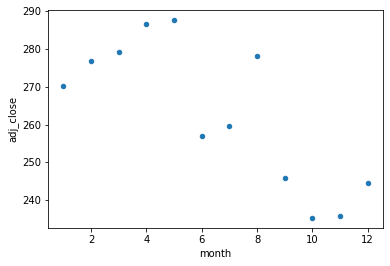

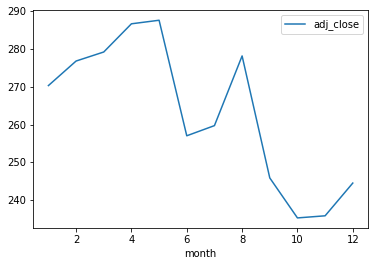

In [14]:
# Compute the average price for each month
avg_price_mth = df.groupby("month").agg({'adj_close': 'mean'}).reset_index()
# avg_price_mth
avg_price_mth.plot.scatter(x = 'month', y = 'adj_close')
avg_price_mth.plot(x = 'month', y = 'adj_close')
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/month-trend.png')
# plt.legend('best')

# # Plot 
# data = [go.Scatter(
#             x = avg_price_mth['month'],
#             y = avg_price_mth['adj_close'],
#             mode = 'markers',
#             marker=dict(
#                 color='LightSkyBlue',
#                 size=15,
#                 line=dict(
#                 color='MediumPurple',
#                 width=2
#                 ))
#         )]

# layout = dict(xaxis = dict(title = 'month'),
#               yaxis = dict(title = 'average adjusted closing price (USD)'))

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='StockPricePrediction_v6d_avg_price_mth')

<Axes: xlabel='day'>

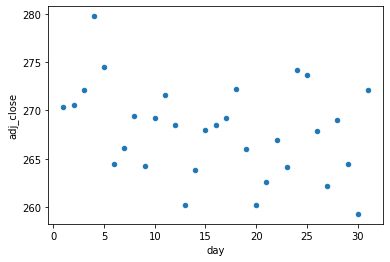

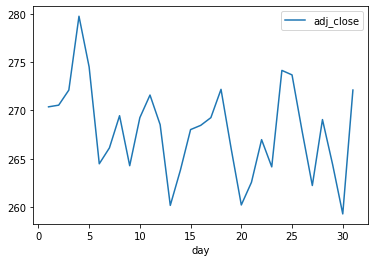

In [15]:
# Compute the average price for each day of month
avg_price_day = df.groupby("day").agg({'adj_close': 'mean'}).reset_index()
avg_price_day
avg_price_day.plot.scatter(x = 'day', y = 'adj_close')
avg_price_day.plot(x = 'day', y = 'adj_close')
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/day-trend.png')

# Plot 
# data = [go.Scatter(
#             x = avg_price_day['day'],
#             y = avg_price_day['adj_close'],
#             mode = 'markers',
#             marker=dict(
#                 color='LightSkyBlue',
#                 size=15,
#                 line=dict(
#                 color='MediumPurple',
#                 width=2
#                 ))
#         )]

# layout = dict(xaxis = dict(title = 'day of month'),
#               yaxis = dict(title = 'average adjusted closing price (USD)'))

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='StockPricePrediction_v6d_avg_price_dayofmonth')

<Axes: xlabel='dayofweek'>

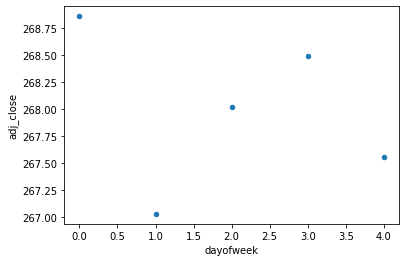

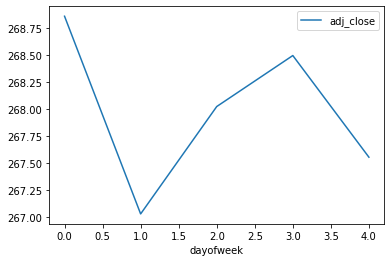

In [16]:
# Compute the average price for each day of week
avg_price_dayofweek = df.groupby("dayofweek").agg({'adj_close': 'mean'}).reset_index()
avg_price_dayofweek
avg_price_dayofweek.plot.scatter(x = 'dayofweek', y = 'adj_close')
avg_price_dayofweek.plot(x = 'dayofweek', y = 'adj_close')

In [17]:
def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') # .fillna(0)
    del train_shift
    
    return df_w_lags

In [18]:
# Create lags 
df_lags = add_lags(df, 10, ['adj_close'])
df_lags

date        open        high         low       close   adj_close  \
0   2022-01-03  335.350006  338.000000  329.779999  334.750000  330.092224   
1   2022-01-04  334.829987  335.200012  326.119995  329.010010  324.432129   
2   2022-01-05  325.859985  326.070007  315.980011  316.380005  311.977875   
3   2022-01-06  313.149994  318.700012  311.489990  313.880005  309.512665   
4   2022-01-07  314.149994  316.500000  310.089996  314.040009  309.670441   
..         ...         ...         ...         ...         ...         ...   
354 2023-05-29         NaN         NaN         NaN         NaN         NaN   
355 2023-05-30         NaN         NaN         NaN         NaN         NaN   
356 2023-05-31         NaN         NaN         NaN         NaN         NaN   
357 2023-06-01         NaN         NaN         NaN         NaN         NaN   
358 2023-06-02         NaN         NaN         NaN         NaN         NaN   

         volume  year  month  week  ...  adj_close_lag_1  adj_close_lag_2  \
0    28865100.0     0      1     1  ...              NaN              NaN   
1    32674300.0     0      1     1  ...       330.092224              NaN   
2    40054300.0     0      1     1  ...       324.432129       330.092224   
3    39646100.0     0      1     1  ...       311.977875       324.432129   
4    32720000.0     0      1     1  ...       309.512665       311.977875   
..          ...   ...    ...   ...  ...              ...              ...   
354         NaN     1      5    22  ...              NaN              NaN   
355         NaN     1      5    22  ...              NaN              NaN   
356         NaN     1      5    22  ...              NaN              NaN   
357         NaN     1      6    22  ...              NaN              NaN   
358         NaN     1      6    22  ...              NaN              NaN   

     adj_close_lag_3  adj_close_lag_4  adj_close_lag_5  adj_close_lag_6  \
0                NaN              NaN              NaN              NaN   
1                NaN              NaN              NaN              NaN   
2                NaN              NaN              NaN              NaN   
3         330.092224              NaN              NaN              NaN   
4         324.432129       330.092224              NaN              NaN   
..               ...              ...              ...              ...   
354       332.890015       325.920013       313.850006       315.260010   
355              NaN       332.890015       325.920013       313.850006   
356              NaN              NaN       332.890015       325.920013   
357              NaN              NaN              NaN       332.890015   
358              NaN              NaN              NaN              NaN   

     adj_close_lag_7  adj_close_lag_8  adj_close_lag_9  adj_close_lag_10  
0                NaN              NaN              NaN               NaN  
1                NaN              NaN              NaN               NaN  
2                NaN              NaN              NaN               NaN  
3                NaN              NaN              NaN               NaN  
4                NaN              NaN              NaN               NaN  
..               ...              ...              ...               ...  
354       321.179993       318.339996       318.519989        314.000000  
355       315.260010       321.179993       318.339996        318.519989  
356       313.850006       315.260010       321.179993        318.339996  
357       325.920013       313.850006       315.260010        321.179993  
358       332.890015       325.920013       313.850006        315.260010  

[359 rows x 30 columns]

In [19]:
df_lags['is_year_end']

0      False
1      False
2      False
3      False
4      False
       ...  
354    False
355    False
356    False
357    False
358    False
Name: is_year_end, Length: 359, dtype: bool

In [20]:
count = 0
for i in range(len(df_lags['is_year_end'])):
    if df_lags['is_year_end'].iloc[i] == True:
        count += 1
#         print(df_lags['is_year_end'].iloc[i])
print(count)

0


In [21]:
# # test correlation, the line below will make the correlation not be nan
# df_lags.loc[0, 'is_year_end'] = True
# df_lags['is_year_end']

In [22]:
import dataframe_image as dfi

In [23]:
# Compute correlation
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
#         'is_year_end',
#         'is_year_start'
]
for n in range(10,0,-1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()
# corr_matrix["adj_close"].sort_values(ascending=False)
# corr_matrix = corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

In [24]:
# dfi.export(corr_matrix, '/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/corr.png')

In [25]:
# Plot correlation for lag features only In[1085]
features = ['adj_close']
for n in range(1, 11, 1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()
# corr1 = corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

In [26]:
# dfi.export(corr1, '/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/corr1.png')

In [27]:
# Plot correlation for date features only
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
#         'is_year_end',
#         'is_year_start'
]
        
corr_matrix = df_lags[features].corr()
# corr2 = corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)
# z_list = []
# for feat in features:
#     z_list.append(corr_matrix.loc[:, feat][features])

# fig = go.Figure(data=go.Heatmap(
#                    z=z_list,
#                    x=features,
#                    y=features))
# py.iplot(fig, filename='StockPricePrediction_v6d_corr_matrix_dates')

In [28]:
# dfi.export(corr2, '/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/corr2.png')

## Split into train, validation, test

In [29]:
252 - 7

245

In [30]:
# pred_day = 245 # Predict for this day, for the next H-1 days. Note indexing of days start from 0.
# H = 39+7 # Forecast horizon, in days. Note there are about 252 trading days in a year
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 313, date 2023-04-03 00:00:00, with forecast horizon H = 39


In [31]:
# train_size = int(252/2)             # Use half year of data as train set. Note there are about 252 trading days in a year
# val_size = int(252/4)                 # Use 1/4 year of data as validation set
train_val_size = train_size + val_size # Size of train+validation set

train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (251, 19)
val.shape = (62, 19)
train_val.shape = (313, 19)
test.shape = (39, 19)


## Predict for a specific H (forecast horizon) and a specific date

In [32]:
# functions used for the following code
def get_error_metrics(df,
                      train_size,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close'])
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df = do_scaling(df, N)
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train_scaled = train[features]
        y_train_scaled = train['adj_close_scaled']
        X_test_ex_adj_close = test[features_ex_adj_close]
        y_test = test['adj_close']
        prev_vals = train[-N:]['adj_close'].to_numpy()
        prev_mean_val = test.iloc[0]['adj_close_mean']
        prev_std_val = test.iloc[0]['adj_close_std']
            
        rmse, mape, mae, est, _ = train_pred_eval_model(X_train_scaled,
                                                        y_train_scaled,
                                                        X_test_ex_adj_close,
                                                        y_test,
                                                        N,
                                                        H,
                                                        prev_vals,
                                                        prev_mean_val,
                                                        prev_std_val,
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict 
model_seed=100
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

In [33]:
# functions used for the following code
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def do_scaling(df, N):
    """
    Do scaling for the adj_close and lag cols
    """
    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    for n in range(N,0,-1):
        df.loc[:, 'adj_close_scaled_lag_'+str(n)] = \
            (df['adj_close_lag_'+str(n)] - df['adj_close_mean']) / df['adj_close_std']
        
        # Remove adj_close_lag column which we don't need anymore
        df.drop(['adj_close_lag_'+str(n)], axis=1, inplace=True)

    return df

def train_pred_eval_model(X_train_scaled,
                          y_train_scaled,
                          X_test_ex_adj_close,
                          y_test,
                          N,
                          H,
                          prev_vals,
                          prev_mean_val,
                          prev_std_val,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        y_test             : target for test. Actual values, not scaled.
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t, 
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est = pred_xgboost(model, X_test_ex_adj_close, N, H, prev_vals, prev_mean_val, prev_std_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mape, mae, est, model.feature_importances_

def pred_xgboost(model, X_test_ex_adj_close, N, H, prev_vals, prev_mean_val, prev_std_val):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t, 
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
    Outputs
        Times series of predictions. Numpy array of shape (H,). This is unscaled.
    """
    forecast = prev_vals.copy()

    for n in range(H):
        forecast_scaled = (forecast[-N:] - prev_mean_val) / prev_std_val
        
        # Create the features dataframe
        X = X_test_ex_adj_close[n:n+1].copy()
        for n in range(N,0,-1):
            X.loc[:, "adj_close_scaled_lag_"+str(n)] = forecast_scaled[-n]
        
        # Do prediction
        est_scaled = model.predict(X)
        
        # Unscale the prediction
        forecast = np.concatenate([forecast, 
                                   np.array((est_scaled * prev_std_val) + prev_mean_val).reshape(1,)])
        
        # Comp. new mean and std
        prev_mean_val = np.mean(forecast[-N:])
        prev_std_val = np.std(forecast[-N:])
           
    return forecast[-H:]

In [34]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [35]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f%%" % mae_bef_tuning)

RMSE = 20.877
MAPE = 6.986%
MAE = 18.164%


## Tuning the model

In [36]:
import plotly.graph_objs as go
import chart_studio.plotly as py
from collections import defaultdict
from tqdm import tqdm_notebook
from pylab import rcParams
import matplotlib
from plotly.offline import iplot

In [37]:
# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

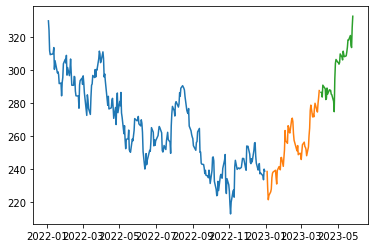

In [38]:
# Plot validation predictions
# fig = go.Figure()

# # Add traces
# fig.add_trace(go.Scatter(x=train['date'], 
#                          y=train['adj_close'],
#                          mode='lines',
#                          name='train',
#                          line=dict(color='blue')))
plt.plot('date', 'adj_close', data=train)

# fig.add_trace(go.Scatter(x=val['date'], 
#                          y=val['adj_close'],
#                          mode='lines',
#                          name='validation',
#                          line=dict(color='orange')))
plt.plot('date', 'adj_close', data=val)

# fig.add_trace(go.Scatter(x=test['date'], 
#                          y=test['adj_close'],
#                          mode='lines',
#                          name='test',
#                          line=dict(color='green')))
plt.plot('date', 'adj_close', data=test)

# # Plot the predictions
# n = 0
# for key in preds_dict:
#     fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
#                              y=preds_dict[key],
#                              mode='lines',
#                              name='predictions',
#                              line=dict(color=colors[n%len(colors)])))
#     n = n + 1

# fig.update_layout(yaxis=dict(title='USD'),
#                   xaxis=dict(title='date'))
# fig.update_xaxes(range=['2017-10-16', '2018-11-12'])
# fig.update_yaxes(range=[127, 157])
# # py.iplot(fig, filename='whatever') # this line is not gonna work
# iplot(fig, filename='whatever')

In [39]:
def get_error_metrics_one_pred(df,
                               train_size,
                               N,
                               H,
                               seed=100,
                               n_estimators=100,
                               max_depth=3,
                               learning_rate=0.1,
                               min_child_weight=1,
                               subsample=1,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               gamma=0):
    """
    Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
    Inputs
        df                 : train + test dataframe. len(df) = train_size + test_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        rmse, mape, mae, predictions
    """    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close'])
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df = do_scaling(df, N)
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    # Split into train and test
    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()
    
    # Drop the NaNs in train
    train.dropna(axis=0, how='any', inplace=True)
    
    # Split into X and y
    X_train_scaled = train[features]
    y_train_scaled = train['adj_close_scaled']
    X_test_ex_adj_close = test[features_ex_adj_close]
    y_test = test['adj_close']
    prev_vals = train[-N:]['adj_close'].to_numpy()
    prev_mean_val = test.iloc[0]['adj_close_mean']
    prev_std_val = test.iloc[0]['adj_close_std']
            
    rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train_scaled,
                                                                      y_train_scaled,
                                                                      X_test_ex_adj_close,
                                                                      y_test,
                                                                      N,
                                                                      H,
                                                                      prev_vals,
                                                                      prev_mean_val,
                                                                      prev_std_val,
                                                                      seed=seed,
                                                                      n_estimators=n_estimators,
                                                                      max_depth=max_depth,
                                                                      learning_rate=learning_rate,
                                                                      min_child_weight=min_child_weight,
                                                                      subsample=subsample,
                                                                      colsample_bytree=colsample_bytree,
                                                                      colsample_bylevel=colsample_bylevel,
                                                                      gamma=gamma)
    
    return rmse, mape, mae, est, feature_importances, features

In [40]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 23.636
MAPE = 6.295%
MAE = 19.503


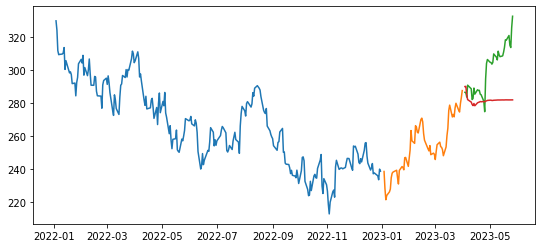

In [41]:
# Plot test predictions
# fig = go.Figure()
plt.figure(figsize=(9, 4))

# # Add traces
# fig.add_trace(go.Scatter(x=train['date'], 
#                          y=train['adj_close'],
#                          mode='lines',
#                          name='train',
#                          line=dict(color='blue')))
plt.plot('date', 'adj_close', data=train)
# fig.add_trace(go.Scatter(x=val['date'], 
#                          y=val['adj_close'],
#                          mode='lines',
#                          name='validation',
#                          line=dict(color='orange')))
plt.plot('date', 'adj_close', data=val)
# fig.add_trace(go.Scatter(x=test['date'], 
#                          y=test['adj_close'],
#                          mode='lines',
#                          name='test',
#                          line=dict(color='green')))
plt.plot('date', 'adj_close', data=test)
# fig.add_trace(go.Scatter(x=test[:H]['date'], 
#                          y=est,
#                          mode='lines',
#                          name='predictions',
#                          line=dict(color='red')))
pred = pd.DataFrame({'date':test[:H]['date'], 'prediction': est})
plt.plot('date', 'prediction', data=pred)
# fig.update_layout(yaxis=dict(title='USD'),
#                   xaxis=dict(title='date'))

In [42]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('month', 0.0062784604),
 ('dayofweek', 0.016945628),
 ('adj_close_scaled_lag_10', 0.030608438),
 ('year', 0.030688094),
 ('day', 0.032071892),
 ('dayofyear', 0.033846114),
 ('adj_close_scaled_lag_9', 0.034116324),
 ('adj_close_scaled_lag_7', 0.034708846),
 ('adj_close_scaled_lag_6', 0.03668274),
 ('week', 0.039168958),
 ('adj_close_scaled_lag_5', 0.03993285),
 ('adj_close_scaled_lag_3', 0.04188733),
 ('adj_close_scaled_lag_2', 0.043175183),
 ('adj_close_scaled_lag_8', 0.049144134),
 ('adj_close_scaled_lag_4', 0.1138378),
 ('adj_close_scaled_lag_1', 0.41690725)]

## Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [43]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [44]:
param_label = 'n_estimators'
param_list = range(1, 61, 2)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate

  0%|          | 0/30 [00:00<?, ?it/s]

Minutes taken = 0.51


n_estimators  max_depth       rmse      mape        mae
0               1          2  17.005574  5.435580  14.145991
1               1          3  17.078009  5.469956  14.235264
2               1          4  17.092438  5.477825  14.255729
3               1          5  17.032429  5.451163  14.185785
4               1          6  17.085350  5.476415  14.251239
..            ...        ...        ...       ...        ...
235            59          5  21.601968  7.321409  19.054156
236            59          6  18.558686  6.152845  16.006150
237            59          7  15.957934  5.143168  13.347272
238            59          8  18.838324  6.136782  15.942732
239            59          9  17.656879  5.764058  14.975791

[240 rows x 5 columns]

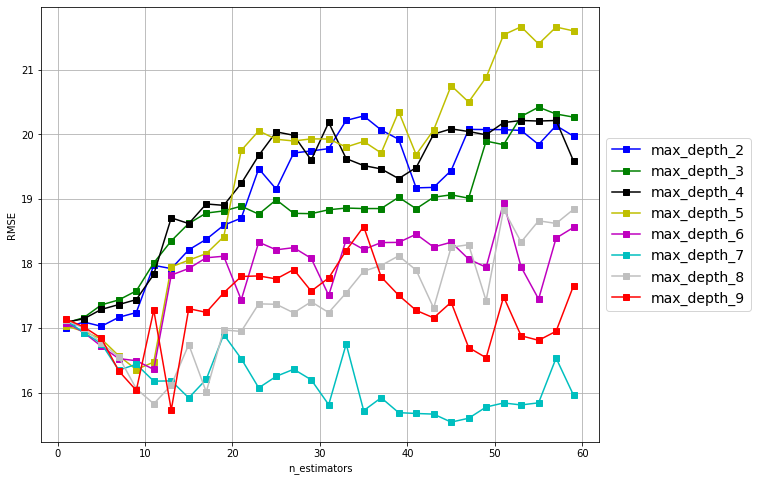

In [45]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [46]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 15.542
optimum params = 


(45, 7)

In [47]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 4.915%
optimum params = 


(13, 9)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [48]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

  0%|          | 0/8 [00:00<?, ?it/s]

Minutes taken = 0.33


learning_rate  min_child_weight       rmse      mape        mae
0           0.0001                 5  17.049095  5.456417  14.200349
1           0.0001                 6  17.051251  5.457488  14.203109
2           0.0001                 7  17.050122  5.457028  14.201907
3           0.0001                 8  17.050948  5.457245  14.202500
4           0.0001                 9  17.051094  5.457343  14.202747
..             ...               ...        ...       ...        ...
123         0.3000                16  14.456381  4.415958  11.449759
124         0.3000                17  24.216161  8.327095  21.610828
125         0.3000                18  23.878350  8.193517  21.298223
126         0.3000                19  22.508689  7.667759  19.947268
127         0.3000                20  20.660651  6.858706  17.796720

[128 rows x 5 columns]

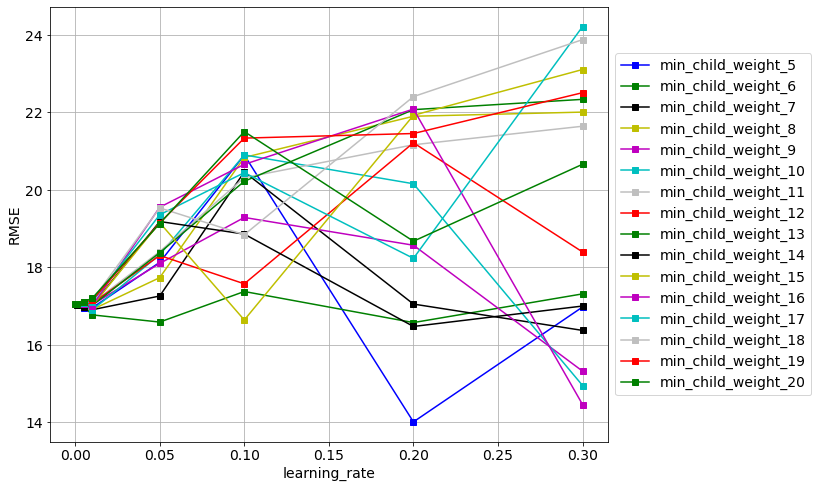

In [49]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [50]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 14.009
optimum params = 


(0.2, 5)

In [51]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 4.416%
optimum params = 


(0.3, 16)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [52]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.25


subsample  gamma       rmse      mape        mae
0          0.1    0.0  23.346087  8.095491  21.012008
1          0.1    0.1  23.346087  8.095491  21.012008
2          0.1    0.2  26.199831  9.042247  23.433296
3          0.1    0.3  23.138330  7.973708  20.705724
4          0.1    0.4  16.898083  5.732939  14.847227
..         ...    ...        ...       ...        ...
105        1.0    0.6  19.488508  6.431798  16.720356
106        1.0    0.7  17.761216  5.664609  14.714392
107        1.0    0.8  17.588858  5.587974  14.512495
108        1.0    0.9  15.182203  4.682555  12.179210
109        1.0    1.0  17.505629  5.637355  14.658042

[110 rows x 5 columns]

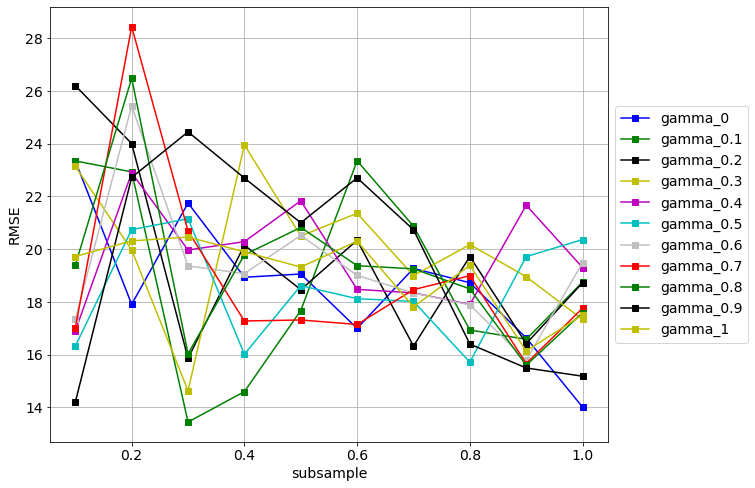

In [53]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [54]:
temp

subsample  gamma       rmse      mape        mae
10         0.1    1.0  19.720437  6.761978  17.556822
21         0.2    1.0  20.313125  6.787137  17.628117
32         0.3    1.0  20.456259  6.755162  17.545254
43         0.4    1.0  19.901526  6.612951  17.176135
54         0.5    1.0  19.319432  6.406466  16.647950
65         0.6    1.0  20.302099  6.910400  17.973892
76         0.7    1.0  17.814369  5.950297  15.440688
87         0.8    1.0  19.380881  6.525707  16.960683
98         0.9    1.0  16.139056  5.086397  13.235112
109        1.0    1.0  17.505629  5.637355  14.658042

In [55]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 13.444
optimum params = 


(0.3, 0.1)

In [56]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 4.214%
optimum params = 


(0.3, 0.1)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [57]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

  0%|          | 0/6 [00:00<?, ?it/s]

Minutes taken = 0.08


colsample_bytree  colsample_bylevel       rmse       mape        mae
0                0.5                0.5  21.714164   7.334656  19.059973
1                0.5                0.6  22.153390   7.431801  19.336970
2                0.5                0.7  17.611210   5.711637  14.859552
3                0.5                0.8  25.360071   8.696189  22.650920
4                0.5                0.9  18.479348   6.143289  15.977519
5                0.5                1.0  20.023082   6.617050  17.172143
6                0.6                0.5  18.868501   6.164797  16.052167
7                0.6                0.6  17.395158   5.516300  14.354372
8                0.6                0.7  19.505623   6.502735  16.875665
9                0.6                0.8  18.729714   6.157616  16.022838
10               0.6                0.9  21.316141   7.144800  18.488370
11               0.6                1.0  22.976952   7.796488  20.238469
12               0.7                0.5  14.687933   4.583857  11.884039
13               0.7                0.6  16.881630   5.438941  14.139246
14               0.7                0.7  21.562938   7.155348  18.563595
15               0.7                0.8  23.962626   7.984345  20.604546
16               0.7                0.9  21.857392   7.365921  19.141381
17               0.7                1.0  21.843208   7.329969  19.071129
18               0.8                0.5  23.509548   8.146734  21.208847
19               0.8                0.6  41.043236  13.945576  36.466695
20               0.8                0.7  28.092399   9.721957  25.192017
21               0.8                0.8  21.764628   7.335394  19.011639
22               0.8                0.9  29.736368  10.358540  26.890529
23               0.8                1.0  19.288338   6.427883  16.720421
24               0.9                0.5  32.710055  11.737363  30.523822
25               0.9                0.6  22.839944   8.056028  20.893007
26               0.9                0.7  21.689492   7.178847  18.615368
27               0.9                0.8  26.436735   9.178767  23.893855
28               0.9                0.9  21.169922   7.184584  18.617910
29               0.9                1.0  17.148904   5.583301  14.482496
30               1.0                0.5  18.956938   6.061930  15.712141
31               1.0                0.6  14.919451   4.621623  11.980983
32               1.0                0.7  20.677937   6.699038  17.381208
33               1.0                0.8  27.364743   9.376332  24.150930
34               1.0                0.9  20.530179   6.720903  17.448872
35               1.0                1.0  13.443914   4.213960  10.871104

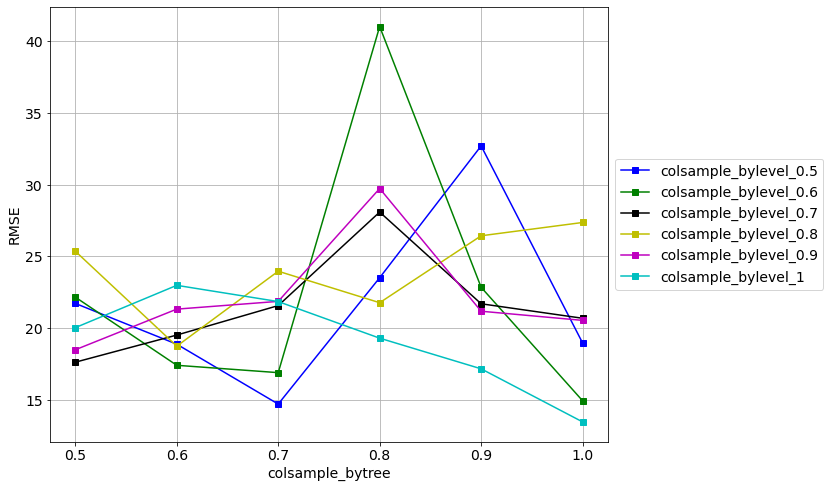

In [58]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [59]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 13.444
optimum params = 


(1.0, 1.0)

In [60]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 4.214%
optimum params = 


(1.0, 1.0)

## Final model

In [61]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 13.444
MAPE = 4.214%
MAE = 10.871


In [62]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

# fig.update_layout(yaxis=dict(title='USD'),
#                   xaxis=dict(title='date'))
# fig.update_xaxes(range=['2017-10-16', '2018-11-12'])
# fig.update_yaxes(range=[127, 157])
iplot(fig, filename='StockPricePrediction_v6d_xgboost_val_aft_tune')

In [63]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 24.363
MAPE = 6.421%
MAE = 19.911


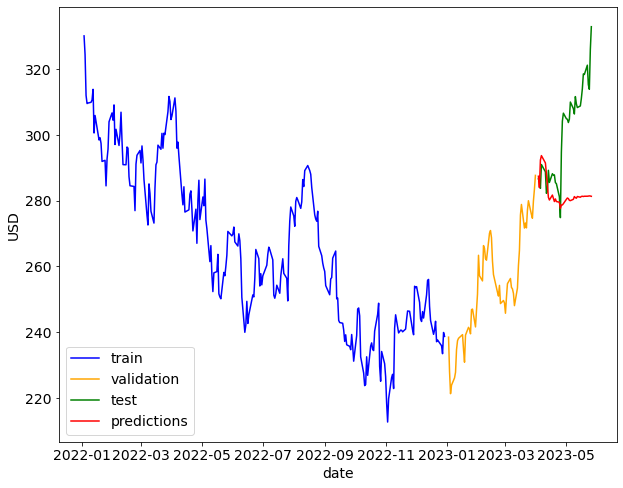

In [64]:
# Plot test predictions
# fig = go.Figure()

# Add traces
# fig.add_trace(go.Scatter(x=train['date'], 
#                          y=train['adj_close'],
#                          mode='lines',
#                          name='train',
#                          line=dict(color='blue')))
plt.plot('date', 'adj_close', data=train, color='blue', label='train')

# fig.add_trace(go.Scatter(x=val['date'], 
#                          y=val['adj_close'],
#                          mode='lines',
#                          name='validation',
#                          line=dict(color='orange')))
plt.plot('date', 'adj_close', data=val, color='orange', label='validation')

# fig.add_trace(go.Scatter(x=test['date'], 
#                          y=test['adj_close'],
#                          mode='lines',
#                          name='test',
#                          line=dict(color='green')))
plt.plot('date', 'adj_close', data=test, color='green', label='test')

# fig.add_trace(go.Scatter(x=test[:H]['date'], 
#                          y=est,
#                          mode='lines',
#                          name='predictions',
#                          line=dict(color='red')))
pred = pd.DataFrame({'date':test[:H]['date'], 'est':est})
plt.plot('date', 'est', data=pred, color='red', label='predictions')
plt.xlabel('date')
plt.ylabel('USD')
plt.legend()

# fig.update_layout(yaxis=dict(title='USD'),
#                   xaxis=dict(title='date'))

In [65]:
est # result

array([287.39910889, 283.96325684, 292.32473755, 293.6802063 ,
       291.45065308, 288.16708374, 284.65661621, 280.9864502 ,
       280.18432617, 281.67999268, 280.68911743, 279.70806885,
       280.50195312, 279.70510864, 279.51226807, 277.59994507,
       278.6831665 , 278.65969849, 279.0569458 , 280.3793335 ,
       280.78378296, 280.60565186, 280.07702637, 279.9810791 ,
       280.39172363, 281.21780396, 280.90771484, 280.72003174,
       281.23248291, 281.02362061, 281.25952148, 281.31503296,
       281.2479248 , 281.32003784, 281.32662964, 281.36782837,
       281.42715454, 281.38851929, 281.30755615])

In [66]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('year', 0.016219782),
 ('adj_close_scaled_lag_9', 0.037581753),
 ('dayofweek', 0.039268464),
 ('week', 0.04302371),
 ('adj_close_scaled_lag_8', 0.04308898),
 ('adj_close_scaled_lag_7', 0.044878922),
 ('adj_close_scaled_lag_4', 0.048021518),
 ('adj_close_scaled_lag_3', 0.048089657),
 ('month', 0.048492346),
 ('adj_close_scaled_lag_10', 0.050526187),
 ('dayofyear', 0.050631396),
 ('adj_close_scaled_lag_2', 0.052013),
 ('adj_close_scaled_lag_5', 0.052194715),
 ('adj_close_scaled_lag_6', 0.053831577),
 ('day', 0.061354477),
 ('is_month_end', 0.10488029),
 ('adj_close_scaled_lag_1', 0.2059032)]

<BarContainer object of 10 artists>

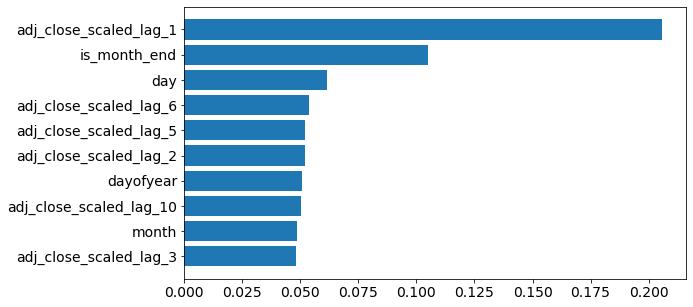

In [67]:
# Plot the importance scores as a bar chart
# fig = go.Figure(go.Bar(
#             x=[item[1] for item in imp[-10:]],
#             y=[item[0] for item in imp[-10:]],
#             orientation='h'))
plt.figure(figsize=(9, 5))
plt.barh([item[0] for item in imp[-10:]], [item[1] for item in imp[-10:]])
# iplot(fig, filename='StockPricePrediction_v6d_xgboost_imp_scores')

In [68]:
## test iplot (done)
# from plotly.offline import iplot
# import plotly.figure_factory as ff
# tic = time.time()
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/school_earnings.csv")

# table = ff.create_table(df)
# iplot(table, filename='jupyter-table1')
# toc = time.time()
# print(toc - tic)

## Tuned params

In [69]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

param  before_tuning  after_tuning
0        n_estimators        100.000        45.000
1           max_depth          3.000         7.000
2       learning_rate          0.100         0.200
3    min_child_weight          1.000         5.000
4           subsample          1.000         0.300
5    colsample_bytree          1.000         1.000
6   colsample_bylevel          1.000         1.000
7               gamma          0.000         0.100
8            val_rmse         20.877        13.444
9            val_mape          6.986         4.214
10            val_mae         18.164        10.871

In [70]:
# to predict the future 7 unseen values
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:],
                                                                       352,
                                                                       N,
                                                                       7,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

est

array([333.63815308, 335.22494507, 334.14044189, 332.94830322,
       336.79907227, 336.21331787, 337.9649353 ])

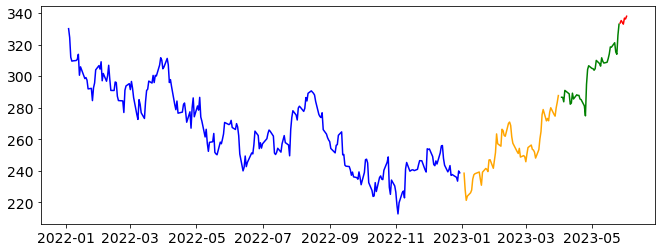

In [71]:
plt.figure(figsize=(11, 4))
plt.plot('date', 'adj_close', data=train, color='blue', label='train')
plt.plot('date', 'adj_close', data=val, color='orange', label='validation')
plt.plot('date', 'adj_close', data=test, color='green', label='test')
pred = pd.DataFrame({'date':df['date'].iloc[-7:], 'adj_close':est})
plt.plot('date', 'adj_close', data=pred, color='red', label='prediction')

In [72]:
last_seen = test['adj_close'].iloc[-1]
pred = est[-1]
pctg = (pred - last_seen) / last_seen * 100
print("The precentage of the future 7th day's price is higher than the prediction day is {0:.2f}%".format(pctg))

The precentage of the future 7th day's price is higher than the prediction day is 1.52%


In [75]:
yf.pdr_override()
check = pdr.get_data_yahoo("MSFT", start="2023-06-02", end="2023-06-03")
real_value = check['Adj Close'].values[0]

[*********************100%***********************]  1 of 1 completed


In [76]:
real_pctg = (real_value - last_seen) / last_seen * 100
print("The real precentage of the future 7th day's price is higher than the prediction day is {0:.2f}%".format(real_pctg))

The real precentage of the future 7th day's price is higher than the prediction day is 0.75%


In [77]:
toc_end = time.time()
print("Total time cost: {0:.2f}min".format((toc_end - tic_begin)/60))

Total time cost: 5.44min
